In [3]:
# !pip install catboost

In [4]:
from catboost import CatBoostClassifier

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(style="whitegrid")

In [6]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [7]:
data = pd.read_csv("/content/UCI_Credit_Card.csv")

In [8]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [9]:
data_to_clean = data.copy()
data_without_id = data_to_clean.drop('ID', axis=1)

In [10]:
data.dtypes

ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL_AMT6                     float64
PAY_AMT1                      float64
PAY_AMT2                      float64
PAY_AMT3                      float64
PAY_AMT4                      float64
PAY_AMT5                      float64
PAY_AMT6                      float64
default.payment.next.month      int64
dtype: object

In [11]:
data_without_id.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [12]:
data_to_clean.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# **Taking a look at:**

1. How many people defaults overall?
2. what is the proportion of education to defauting
3. Age group of defaulters
4. Will be interesting to see if people started defaulting when they clocked retirement?


According to ChatGPT, Bill Statement is a document that provides a summary of financial transactions between two parties over a specific period. It is commonly associated with various types of accounts, such as credit cards, utility services, subscriptions, or loans. **The purpose of a bill statement is to inform the recipient of the charges, payments, and other relevant details related to the account**.


In [13]:
# data_to_clean.isnull().sum() # No null data

In [14]:
# Renamed the predictor column

data_to_clean.rename(columns={'default.payment.next.month':'_default'}, inplace=True)


# **Feature Engineering**

In [15]:
# data_to_clean.columns
columns = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       '_default']

In [16]:
data_to_clean['total_bill'] = data_to_clean.iloc[:,11:17].sum(axis=1)
data_to_clean['total_payment'] = data_to_clean.iloc[:,17:23].sum(axis=1)

'''
Credit utilization ratio is the ratio of credit used to the total credit available.
A good credit utilization ratio is such that is kept under 30%.
Credit utilization ratio above 30% is usually considered as
'''

data_to_clean['Credit_util_ratio'] = (data_to_clean['total_bill']-data_to_clean['total_payment'])/data_to_clean['LIMIT_BAL']*100
# data_to_clean

In [17]:
data_to_clean

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,_default,total_bill,total_payment,Credit_util_ratio
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,7702.0,689.0,35.065000
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,13818.0,6261.0,6.297500
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,86104.0,21567.0,71.707778
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,201787.0,36935.0,329.704000
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,90208.0,77501.0,25.414000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0,709369.0,57530.0,296.290455
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0,21182.0,14490.0,4.461333
29997,29998,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1,51139.0,47557.0,11.940000
29998,29999,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1,217666.0,194321.0,29.181250


In [18]:

age_bin = [0, 16, 25, 35, 64, 100]
_group = ['0-15', '16-24', '25-34','35-64', '65+']

data_to_clean['age_group'] = pd.cut(data_to_clean['AGE'], bins=age_bin, labels=_group, right=False)
data_to_clean['age_group'] = pd.Categorical(data_to_clean['age_group'], categories=_group)

# **EDA**

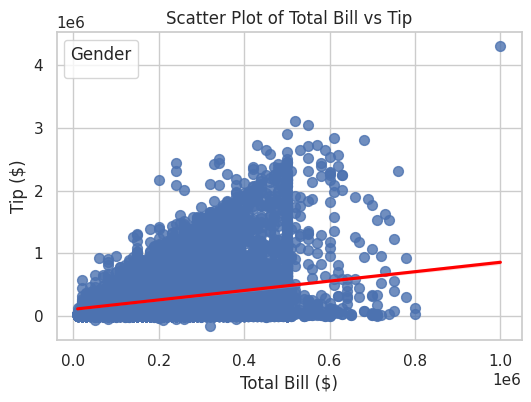

In [19]:
plt.figure(figsize=(6, 4))

sns.regplot(x='LIMIT_BAL', y='total_bill', data=data_to_clean, scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Set labels and title
plt.xlabel('Total Bill ($)')
plt.ylabel('Tip ($)')
plt.title('Scatter Plot of Total Bill vs Tip')

# Show the legend
plt.legend(title='Gender')

<ipython-input-20-e78fac592301>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='age_group', y='total_bill', data=data_to_clean, ci=None)


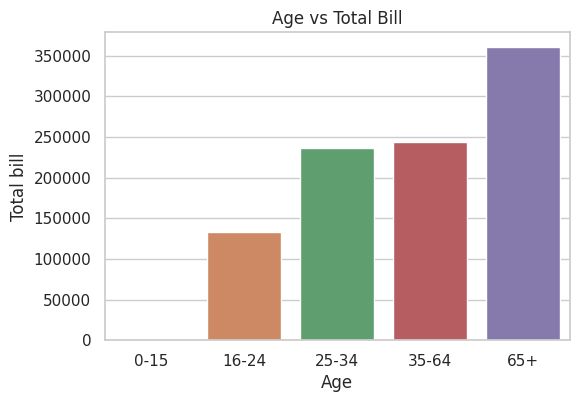

In [20]:
plt.figure(figsize=(6, 4))
sns.barplot(x='age_group', y='total_bill', data=data_to_clean, ci=None)
plt.title('Age vs Total Bill')
plt.xlabel('Age')
plt.ylabel('Total bill')
plt.show()

In [21]:
categorical_features = ['ID', 'SEX', 'EDUCATION', 'MARRIAGE','LIMIT_BAL', 'total_bill', 'total_payment']

sex_map = {1:"male", 2:"female"}
edu_map = {1:'graduate school', 2:'university', 3:'high school', 4:'others', 5:'unknown', 6:'unknown'}
mage_map = {1:'married', 2:'single',3:'others'}

categorical_data = data_to_clean[categorical_features]

categorical_data['SEX'].replace(sex_map, inplace=True)
categorical_data['EDUCATION'].replace(edu_map, inplace=True)
categorical_data['MARRIAGE'].replace(mage_map, inplace=True)


<ipython-input-21-1eab4edd311a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_data['SEX'].replace(sex_map, inplace=True)
<ipython-input-21-1eab4edd311a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_data['EDUCATION'].replace(edu_map, inplace=True)
<ipython-input-21-1eab4edd311a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_data['MARRIAGE'].replace(mage_map, inplace=True)


<ipython-input-22-47dc542577a8>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='EDUCATION', y='total_bill', data=categorical_data, ci=None)


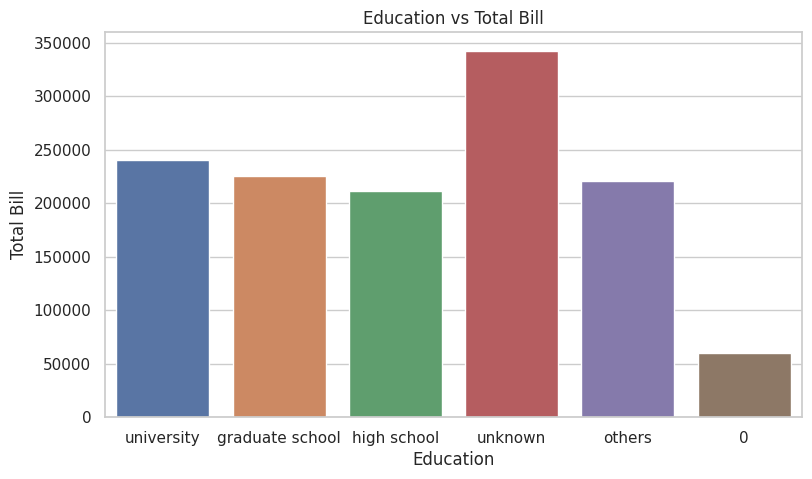

In [22]:
plt.figure(figsize=(9, 5))
sns.barplot(x='EDUCATION', y='total_bill', data=categorical_data, ci=None)
plt.title('Education vs Total Bill')
plt.xlabel('Education')
plt.ylabel('Total Bill')
plt.show()

<ipython-input-23-cf83c76fd759>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='EDUCATION', y='total_payment', data=categorical_data, ci=None)


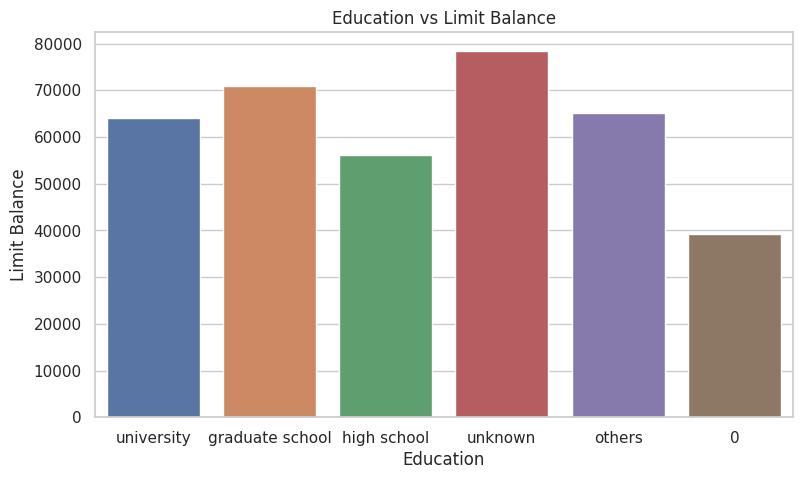

In [23]:
plt.figure(figsize=(9, 5))
sns.barplot(x='EDUCATION', y='total_payment', data=categorical_data, ci=None)
plt.title('Education vs Limit Balance')
plt.xlabel('Education')
plt.ylabel('Limit Balance')
plt.show()

<ipython-input-24-c27f822d67cb>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='MARRIAGE', y='total_payment', data=categorical_data, ci=None)


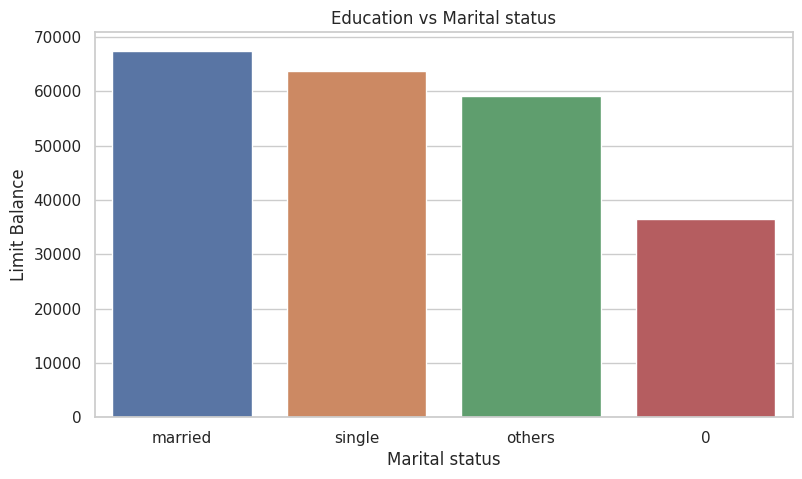

In [24]:
plt.figure(figsize=(9, 5))
sns.barplot(x='MARRIAGE', y='total_payment', data=categorical_data, ci=None)
plt.title('Education vs Marital status')
plt.xlabel('Marital status')
plt.ylabel('Limit Balance')
plt.show()

In [25]:
negative_columns = ['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
negative_data = data_to_clean[(data_to_clean[negative_columns]<0).all(axis=1)]

clean_data = data_to_clean[(data_to_clean[negative_columns]>=0).all(axis=1)]

In [26]:
clean_data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,_default,total_bill,total_payment,Credit_util_ratio,age_group
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,7702.0,689.0,35.065000,16-24
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,13818.0,6261.0,6.297500,25-34
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,86104.0,21567.0,71.707778,25-34
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,201787.0,36935.0,329.704000,35-64
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,90208.0,77501.0,25.414000,35-64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,29995,80000.0,1,2,2,34,2,2,2,2,2,2,72557.0,77708.0,79384.0,77519.0,82607.0,81158.0,7000.0,3500.0,0.0,7000.0,0.0,4000.0,1,389777.0,98658.0,363.898750,25-34
29995,29996,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0,709369.0,57530.0,296.290455,35-64
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0,21182.0,14490.0,4.461333,35-64
29997,29998,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1,51139.0,47557.0,11.940000,35-64


In [27]:
clean_data_columns = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'total_bill', 'total_payment', 'Credit_util_ratio', '_default']

clean_data = clean_data[clean_data_columns]

In [28]:
from sklearn.model_selection import train_test_split

X = clean_data.iloc[:,:len(clean_data_columns)-1]
y = clean_data['_default']

In [29]:
clean_data['_default'].value_counts()

0    21752
1     6318
Name: _default, dtype: int64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 40)

In [31]:
from imblearn.combine import SMOTETomek
smote = SMOTETomek(sampling_strategy =0.8, random_state=40 )
X_res,y_res=smote.fit_resample(X_train,y_train)

In [32]:
y_res.value_counts()

0    16802
1    13311
Name: _default, dtype: int64

In [33]:
X_test.shape

(5614, 26)

In [34]:
import pickle
def scaling(X_res, X_test):
  scaler = MinMaxScaler()
  scaler.fit(X_res)
  X_train_scaled = scaler.transform(X_res)
  X_test_scaled = scaler.transform(X_test)
  file = open('/content/min_max.pkl','wb')
  pickle.dump(scaler,file)
  file.close()
  return X_train_scaled, X_test_scaled

In [35]:
X_train_scaled, X_test_scaled= scaling(X_res, X_test)

In [36]:
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [37]:
model = CatBoostClassifier()
model.fit(X_train_scaled, y_res)


Learning rate set to 0.044092
0:	learn: 0.6772070	total: 64.3ms	remaining: 1m 4s
1:	learn: 0.6630165	total: 78.1ms	remaining: 39s
2:	learn: 0.6509857	total: 90.8ms	remaining: 30.2s
3:	learn: 0.6403765	total: 104ms	remaining: 26s
4:	learn: 0.6311310	total: 118ms	remaining: 23.5s
5:	learn: 0.6230178	total: 131ms	remaining: 21.7s
6:	learn: 0.6145850	total: 147ms	remaining: 20.8s
7:	learn: 0.6068146	total: 162ms	remaining: 20s
8:	learn: 0.5992052	total: 175ms	remaining: 19.2s
9:	learn: 0.5928775	total: 188ms	remaining: 18.6s
10:	learn: 0.5877103	total: 205ms	remaining: 18.5s
11:	learn: 0.5801673	total: 218ms	remaining: 18s
12:	learn: 0.5739320	total: 231ms	remaining: 17.6s
13:	learn: 0.5692759	total: 245ms	remaining: 17.3s
14:	learn: 0.5630921	total: 260ms	remaining: 17.1s
15:	learn: 0.5593519	total: 273ms	remaining: 16.8s
16:	learn: 0.5557137	total: 286ms	remaining: 16.5s
17:	learn: 0.5520713	total: 299ms	remaining: 16.3s
18:	learn: 0.5485859	total: 313ms	remaining: 16.1s
19:	learn: 0.545

In [38]:
len(X_res.columns)

26

In [39]:
y_pred = model.predict(X_test_scaled)

In [40]:
y_pred

array([0, 0, 1, ..., 0, 0, 1])

In [41]:
y_test.shape

(5614,)

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

cm

array([[3815,  486],
       [ 696,  617]])

In [43]:
true_positive = cm[0][0]
false_positive = cm[0][1]
false_negative = cm[1][0]
true_negative = cm[1][1]

In [44]:
Accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
Accuracy

0.7894549340933381

In [45]:
Precision = true_positive/(true_positive+false_positive)
Precision

0.8870030225528946

In [46]:
Recall = true_positive/(true_positive+false_negative)
Recall

0.8457104854799379

In [47]:
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

0.8658647299137538

In [48]:
print('Accuracy: ', Accuracy)
print('Precision:', Precision)
print('Recall: ', Recall)
print('F1_score: ', F1_Score)



Accuracy:  0.7894549340933381
Precision: 0.8870030225528946
Recall:  0.8457104854799379
F1_score:  0.8658647299137538


In [50]:
file = open('/content/catboost_model.pkl','wb')
pickle.dump(model,file)
file.close()


# **Limitations of the dataset**

1. No information about the employment status of the customers, while age can provide insight into this, it is not wholesome.
2. No information about the country/economic situation of the country, e.g., inflation, as this is also a major factor that affects spendings of customers.

# **Outliers**

In credit risk data, a high values may not indicate the present of outlier. It may be the true representation of the customer's earning and debt profile. Therefore, all values are left intact and scaled before fed into the model.
